![](img/330-banner.png)

# Lecture 6: `sklearn` `ColumnTransformer` and Text Features

UBC 2022-23

Instructor: Varada Kolhatkar

## Imports, Announcements, and LO

### Imports

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import HTML

sys.path.append("code/.")
from plotting_functions import *
from utils import *

pd.set_option("display.max_colwidth", 200)

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

ModuleNotFoundError: No module named 'torchvision'

### Announcements

- Homework 3 is due on Oct 3rd. 
- Friday is a holiday. So no tutorial this Friday. 
- Scheduled extra office hours this week. 
    - Check the [Calendar](https://htmlpreview.github.io/?https://github.com/UBC-CS/cpsc330/blob/master/docs/calendar.html).
- We're working on Homework 2 grading. The grades will be released in a couple of days. 

### Learning outcomes 

From this lecture, you will be able to 

- use `ColumnTransformer` to build all our transformations together into one object and use it with `sklearn` pipelines;  
- define `ColumnTransformer` where transformers contain more than one steps;
- explain `handle_unknown="ignore"` hyperparameter of `scikit-learn`'s `OneHotEncoder`;
- explain `drop="if_binary"` argument of `OneHotEncoder`;
- identify when it's appropriate to apply ordinal encoding vs one-hot encoding;
- explain strategies to deal with categorical variables with too many categories; 
- explain why text data needs a different treatment than categorical variables;
- use `scikit-learn`'s `CountVectorizer` to encode text data;
- explain different hyperparameters of `CountVectorizer`.

<br><br><br><br>

## sklearn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html)

- In most applications, some features are categorical, some are continuous, some are binary, and some are ordinal. 

- When we want to develop supervised machine learning pipelines on real-world datasets, very often we want to apply different transformation on different columns.
    - We want to apply different transformations on different features. But, we can't really use that using pipelines. In pipelines, we can chain together transformations but it doesn't really make sense to chain one hot encoder and scaling since will try to apply these to all columns. It will try to apply one hot encoding to numeric features and scaling to categorical features. 

- Enter `sklearn`'s `ColumnTransformer`!! 
    - ColumnTransformer allows you to apply different transformations to different features. Does it in single object so can pass the object to pipeline.

- Let's look at a toy example: 

In [2]:
df = pd.read_csv("data/quiz2-grade-toy-col-transformer.csv")
df

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1,quiz2
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92,A+
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91,not A+
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80,not A+
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89,A+
4,yes,0,Psychology,Good,4,77,83.0,90,92,85,A+
5,no,1,Economics,Good,5,70,73.0,68,74,71,not A+
6,yes,1,Computer Science,Excellent,4,80,88.0,89,88,91,A+
7,no,0,Mechanical Engineering,Poor,3,95,93.0,69,79,75,not A+
8,no,0,Linguistics,Average,2,97,90.0,94,82,80,not A+
9,yes,1,Mathematics,Average,4,95,82.0,94,94,85,not A+


numeric_features = ['lab1', 'lab3', 'lab4', 'quiz1', 'university_years']  
categorical_features = ['major']

Can we do the following:  
pipe = make_pipeline(StandardScaler(), OnehotEncoder(), SVC())  
**No**. This saying, apply standardscaler to ALL columns. How do we do that to the major feature? It does not make sense to apply scaling to categories. Also, how would we apply one hot encoding to numeric features? In pipelining, we apply the transformation to ALL columns.  
This breaks golden rule. If we apply all transformation to data before sending to crossvalidate, will break golden rule.  
X_train y_train
X_train_preprocessed  
cross_validate(SVC, X_train_preprocessed, y_train)  
What happens inside of cross_validate now? It will split into train and validate folds. BUT, technically the validate fold has been transformed already with train fold influence (ex: standardscaler will make mean 0. That means validate fold was scaled based on both the validate AND train folds).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   enjoy_course      21 non-null     object 
 1   ml_experience     21 non-null     int64  
 2   major             21 non-null     object 
 3   class_attendance  21 non-null     object 
 4   university_years  21 non-null     int64  
 5   lab1              21 non-null     int64  
 6   lab2              19 non-null     float64
 7   lab3              21 non-null     int64  
 8   lab4              21 non-null     int64  
 9   quiz1             21 non-null     int64  
 10  quiz2             21 non-null     object 
dtypes: float64(1), int64(6), object(4)
memory usage: 1.9+ KB


### Transformations on the toy data

In [4]:
df.head()

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1,quiz2
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92,A+
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91,not A+
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80,not A+
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89,A+
4,yes,0,Psychology,Good,4,77,83.0,90,92,85,A+


- Scaling on numeric features
    - university_years, labs, quizzes
- One-hot encoding on the categorical feature `major` and binary feature `enjoy_class`
- Ordinal encoding on the ordinal feature `class_attendance`
    - Ordinal: ordinary between the features
    - Excellent -> Good -> Average -> Poor
- Imputation on the `lab2` feature
    - There is missing features in lab2 
- None on the `ml_experience` feature

### `ColumnTransformer` example

#### Data

In [5]:
X = df.drop(columns=["quiz2"])
y = df["quiz2"]
X.columns

Index(['enjoy_course', 'ml_experience', 'major', 'class_attendance',
       'university_years', 'lab1', 'lab2', 'lab3', 'lab4', 'quiz1'],
      dtype='object')

#### Identify the transformations we want to apply

In [6]:
X.head()

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89
4,yes,0,Psychology,Good,4,77,83.0,90,92,85


In [7]:
numeric_feats = ["university_years", "lab1", "lab3", "lab4", "quiz1"]  # apply scaling
categorical_feats = ["major"]  # apply one-hot encoding
passthrough_feats = ["ml_experience"]  # do not apply any transformation
drop_feats = [
    "lab2", # drop since has missing values
    "class_attendance",
    "enjoy_course",
]  # do not include these features in modeling

For simplicity, let's only focus on scaling and one-hot encoding first. 

#### Create a column transformer

- Each transformation is specified by a name, a transformer object, and the columns this transformer should be applied to. 

In [8]:
from sklearn.compose import ColumnTransformer

In [9]:
ct = ColumnTransformer(
    [
        ("scaling", StandardScaler(), numeric_feats),
        ("onehot", OneHotEncoder(sparse=False), categorical_feats),
    ]
)

#### Convenient `make_column_transformer` syntax

- Similar to `make_pipeline` syntax, there is convenient `make_column_transformer` syntax. 
- The syntax automatically names each step based on its class. 
    - Names will be lower case of the class
- We'll be mostly using this syntax. 

In [10]:
from sklearn.compose import make_column_transformer

ct = make_column_transformer(
    (StandardScaler(), numeric_feats),  # scaling on numeric features
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    ("passthrough", passthrough_feats),  # no transformations on the binary features
    ("drop", drop_feats),  # drop the drop features
)

**Do we have to specify the drop features in `make_column_transformer`?** 
Technically, we do not need to include it, only he columns we included would be considered. But, by explicitly including it, it makes it clear that we are not including these. 



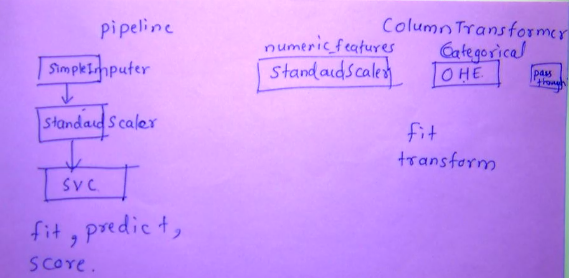
In pipeline, this is all happening sequentially.  
In columntransformer, this is all happening parallely.   
Can we call `fit` on a pipeline?  
Yes, regardless of if we have an estimator at the end.  
Can we call `fit` on a columntransformer?  
Yes, it will just call fit for all the transformers. But, it doesn't really make sense to call predict or score since there is no estimator. 

In [11]:
ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['university_years', 'lab1', 'lab3', 'lab4',
                                  'quiz1']),
                                ('onehotencoder', OneHotEncoder(), ['major']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('drop', 'drop',
                                 ['lab2', 'class_attendance', 'enjoy_course'])])

In [12]:
transformed = ct.fit_transform(X)

- When we `fit_transform`, each transformer is applied to the specified columns and the result of the transformations are concatenated horizontally. 
- A big advantage here is that we build all our transformations together into one object, and that way we're sure we do the same operations to all splits of the data.
- Otherwise we might, for example, do the OHE on both train and test but forget to scale the test data.
- Helps us to make sure we do not break golden rule!
    - We can pass column transformer to pipeline and have an estimator after. We can then pass the pipeline to cross validate. 

#### Let's examine the transformed data

In [13]:
type(transformed[:2])

numpy.ndarray

In [14]:
transformed

array([[-0.09345386,  0.3589134 , -0.21733442,  0.36269995,  0.84002795,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [-1.07471942,  0.59082668, -0.61420598, -0.85597188,  0.71219761,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  1.        ],
       [-0.09345386, -1.26447953, -0.31655231, -1.31297381, -0.69393613,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-0.09345386,  0.24295676,  0.57640869,  0.36269995,  0.45653693,
         0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.8878117 , -1.38043616,  0.37797291,  0.51503393, -0.05478443,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.  

```{note}
Note that the returned object is not a dataframe. So there are no column names. 
```

#### Viewing the transformed data as a dataframe

- How can we view our transformed data as a dataframe? 
- We are adding more columns. 
    - One hot encoding adds columns
- So the original columns won't directly map to the transformed data. 
- Let's create column names for the transformed data. 

In [15]:
column_names = (
    numeric_feats
    + ct.named_transformers_["onehotencoder"].get_feature_names().tolist()
    + passthrough_feats
)
column_names

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['university_years',
 'lab1',
 'lab3',
 'lab4',
 'quiz1',
 'x0_Biology',
 'x0_Computer Science',
 'x0_Economics',
 'x0_Linguistics',
 'x0_Mathematics',
 'x0_Mechanical Engineering',
 'x0_Physics',
 'x0_Psychology',
 'ml_experience']

In [16]:
ct.named_transformers_

{'standardscaler': StandardScaler(),
 'onehotencoder': OneHotEncoder(),
 'passthrough': 'passthrough',
 'drop': 'drop'}

```{note}
Note that the order of the columns in the transformed data depends upon the order of the features we pass to the `ColumnTransformer` and can be different than the order of the features in the original dataframe.  
```

In [17]:
pd.DataFrame(transformed, columns=column_names)

,university_years,lab1,lab3,lab4,quiz1,x0_Biology,x0_Computer Science,x0_Economics,x0_Linguistics,x0_Mathematics,x0_Mechanical Engineering,x0_Physics,x0_Psychology,ml_experience
0,-0.093454,0.358913,-0.217334,0.362700,0.840028,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-1.074719,0.590827,-0.614206,-0.855972,0.712198,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,-0.093454,-1.264480,-0.316552,-1.312974,-0.693936,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-0.093454,0.242957,0.576409,0.362700,0.456537,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.887812,-1.380436,0.377973,0.515034,-0.054784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,1.869077,-2.192133,-1.804821,-2.226978,-1.844409,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0.887812,-1.032566,0.278755,-0.094302,0.712198,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7,-0.093454,0.706783,-1.705603,-1.465308,-1.333088,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,-1.074719,0.938697,0.774844,-1.008306,-0.693936,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,0.887812,0.706783,0.774844,0.819702,-0.054784,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


#### `ColumnTransformer`: Transformed data

<br>

<img src='./img/column-transformer.png' width="1500">

[Adapted from here.](https://amueller.github.io/COMS4995-s20/slides/aml-04-preprocessing/#37)

#### Training models with transformed data
- We can now pass the `ColumnTransformer` object as a step in a pipeline. 

In [18]:
pipe = make_pipeline(ct, SVC())
pipe.fit(X, y)
pipe.predict(X)

array(['A+', 'not A+', 'not A+', 'A+', 'A+', 'not A+', 'A+', 'not A+',
       'not A+', 'A+', 'A+', 'A+', 'A+', 'A+', 'not A+', 'not A+', 'A+',
       'not A+', 'not A+', 'not A+', 'A+'], dtype=object)

## ❓❓ Questions for you 

### (iClicker) Exercise 6.1 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

1. You could carry out cross-validation by passing a `ColumnTransformer` object to `cross_validate`. 
2. After applying column transformer, the order of the columns in the transformed data has to be the same as the order of the columns in the original data. 
3. After applying a column transformer, the transformed data is always going to be of different shape than the original data. 
4. When you call `fit_transform` on a `ColumnTransformer` object, you get a numpy ndarray. 

1. False. ColumnTransformer is for preprocessing and there is no estimator. If you are cross validating, you want to score your model but ColumnTransformer has no "model". You would need to create a pipeline with a ColumnTransformer and an estimator and then pass that to cross validate. 
2. False. In ColumnTransformer, you can have any order you like. 
3. False. Ex: one hot encoding will add more columns but if you have just pass through or scaler columns, data will be same shape.  
4. **True**. You will not get a nice dataframe. 

#### What transformations on what columns? 
Consider the feature columns below. 

- What transformations would you apply on each column? 

| colour  | location  |  shape |  water_content | weight |
|-----|-----|-----|-----|-----|
|   red   |   canada  |    NaN  |       84  |        100 |
| yellow  |   mexico  |   long  |       75  |        120 |
| orange  |   spain   |    NaN  |       90  |        NaN |
| magenta |    china  |    round|       NaN |        600 |
| purple  |  austria  |    NaN  |       80  |        115 |
| purple  |  turkey   |   oval  |       78  |        340 |
| green   |  mexico   |   oval  |       83  |        NaN |
| blue    | canada     | round  |      73   |       535  |
| brown   |  china     |   NaN  |       NaN |       1743 | 
| yellow  |  mexico    |  oval  |       83  |        265 |


<br><br><br><br>

## More on feature transformations

### Multiple transformations in a transformer

- Recall that `lab2` has missing values. 


In [19]:
X.head(10)

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89
4,yes,0,Psychology,Good,4,77,83.0,90,92,85
5,no,1,Economics,Good,5,70,73.0,68,74,71
6,yes,1,Computer Science,Excellent,4,80,88.0,89,88,91
7,no,0,Mechanical Engineering,Poor,3,95,93.0,69,79,75
8,no,0,Linguistics,Average,2,97,90.0,94,82,80
9,yes,1,Mathematics,Average,4,95,82.0,94,94,85


- So we would like to apply more than one transformations on it: imputation and scaling.  
- We can treat `lab2` separately, but we can also include it into `numeric_feats` and apply both transformations on all numeric columns.

In [20]:
numeric_feats = [
    "university_years",
    "lab1",
    "lab2",
    "lab3",
    "lab4",
    "quiz1",
]  # apply scaling
categorical_feats = ["major"]  # apply one-hot encoding
passthrough_feats = ["ml_experience"]  # do not apply any transformation
drop_feats = ["class_attendance", "enjoy_course"]

- To apply more than one transformations we can define a pipeline inside a column transformer to chain different transformations. 

In [21]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numeric_feats,
    ),  # scaling on numeric features
    ("passthrough", passthrough_feats),  # no transformations on the binary features    
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features
    ("drop", drop_feats),  # drop the drop features
)

In [22]:
X_transformed = ct.fit_transform(X)

In [23]:
column_names = (
    numeric_feats
    + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['university_years',
 'lab1',
 'lab2',
 'lab3',
 'lab4',
 'quiz1',
 'ml_experience',
 'major_Biology',
 'major_Computer Science',
 'major_Economics',
 'major_Linguistics',
 'major_Mathematics',
 'major_Mechanical Engineering',
 'major_Physics',
 'major_Psychology']

In [24]:
pd.DataFrame(X_transformed, columns=column_names)

,university_years,lab1,lab2,lab3,lab4,quiz1,ml_experience,major_Biology,major_Computer Science,major_Economics,major_Linguistics,major_Mathematics,major_Mechanical Engineering,major_Physics,major_Psychology
0,-0.093454,0.358913,0.893260,-0.217334,0.362700,0.840028,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.074719,0.590827,0.294251,-0.614206,-0.855972,0.712198,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.093454,-1.264480,-0.704099,-0.316552,-1.312974,-0.693936,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.093454,0.242957,0.000000,0.576409,0.362700,0.456537,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.887812,-1.380436,-1.103439,0.377973,0.515034,-0.054784,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.869077,-2.192133,-3.100139,-1.804821,-2.226978,-1.844409,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.887812,-1.032566,-0.105089,0.278755,-0.094302,0.712198,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.093454,0.706783,0.893260,-1.705603,-1.465308,-1.333088,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,-1.074719,0.938697,0.294251,0.774844,-1.008306,-0.693936,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.887812,0.706783,-1.303109,0.774844,0.819702,-0.054784,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<br><br>

### `sklearn` `set_config`

- With multiple transformations in a column transformer, it can get tricky to keep track of everything happening inside it.  
- We can use `set_config` to display a diagram of this. 

In [25]:
from sklearn import set_config

set_config(display="diagram")

In [26]:
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['university_years', 'lab1', 'lab2', 'lab3',
                                  'lab4', 'quiz1']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('onehotencoder', OneHotEncoder(), ['major']),
                                ('drop', 'drop',
                                 ['class_attendance', 'enjoy_course'])])

In [27]:
print(ct)

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['university_years', 'lab1', 'lab2', 'lab3',
                                  'lab4', 'quiz1']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('onehotencoder', OneHotEncoder(), ['major']),
                                ('drop', 'drop',
                                 ['class_attendance', 'enjoy_course'])])


<br><br>

### Incorporating ordinal feature `class_attendance` 

- The `class_attendance` column is different than the `major` column in that there is some ordering of the values. 
    - Excellent > Good > Average > poor    

In [28]:
X.head()

,enjoy_course,ml_experience,major,class_attendance,university_years,lab1,lab2,lab3,lab4,quiz1
0,yes,1,Computer Science,Excellent,3,92,93.0,84,91,92
1,yes,1,Mechanical Engineering,Average,2,94,90.0,80,83,91
2,yes,0,Mathematics,Poor,3,78,85.0,83,80,80
3,no,0,Mathematics,Excellent,3,91,NaN,92,91,89
4,yes,0,Psychology,Good,4,77,83.0,90,92,85


Let's try applying `OrdinalEncoder` on this column. 

In [29]:
X_toy = X[["class_attendance"]]
enc = OrdinalEncoder()
enc.fit(X_toy)
X_toy_ord = enc.transform(X_toy)
df = pd.DataFrame(
    data=X_toy_ord,
    columns=["class_attendance_enc"],
    index=X_toy.index,
)

In [30]:
pd.concat([X_toy, df], axis=1).head(10)

,class_attendance,class_attendance_enc
0,Excellent,1.0
1,Average,0.0
2,Poor,3.0
3,Excellent,1.0
4,Good,2.0
5,Good,2.0
6,Excellent,1.0
7,Poor,3.0
8,Average,0.0
9,Average,0.0


- What's the problem here? 
    - The encoder doesn't know the order. 
    - The encoder just ordered them alphabetically and gave them values.  
- We can examine unique categories manually, order them based on our intuitions, and then provide this human knowledge to the transformer. 

What are the unique categories of `class_attendance`? 

In [31]:
X_toy["class_attendance"].unique()

array(['Excellent', 'Average', 'Poor', 'Good'], dtype=object)

Let's order them manually. 

In [32]:
class_attendance_levels = ["Poor", "Average", "Good", "Excellent"]

```{note}
Note that if you use the reverse order of the categories, it wouldn't matter. 
```

Let's make sure that we have included all categories in our manual ordering.  

In [33]:
assert set(class_attendance_levels) == set(X_toy["class_attendance"].unique())

In [34]:
oe = OrdinalEncoder(categories=[class_attendance_levels], dtype=int)
oe.fit(X_toy[["class_attendance"]])
ca_transformed = oe.transform(X_toy[["class_attendance"]])
df = pd.DataFrame(
    data=ca_transformed, columns=["class_attendance_enc"], index=X_toy.index
)
print(oe.categories_)
pd.concat([X_toy, df], axis=1).head(10)

[array(['Poor', 'Average', 'Good', 'Excellent'], dtype=object)]


,class_attendance,class_attendance_enc
0,Excellent,3
1,Average,1
2,Poor,0
3,Excellent,3
4,Good,2
5,Good,2
6,Excellent,3
7,Poor,0
8,Average,1
9,Average,1


The encoded categories are looking better now! 

#### More than one ordinal columns?

- We can pass the manually ordered categories when we create an `OrdinalEncoder` object as a list of lists. 
- If you have more than one ordinal columns
    - manually create a list of ordered categories for each column
    - pass a list of lists to `OrdinalEncoder`, where each inner list corresponds to manually created list of ordered categories for a corresponding ordinal column. 
    

Now let's incorporate ordinal encoding of `class_attendance` in our column transformer. 

In [35]:
numeric_feats = [
    "university_years",
    "lab1",
    "lab2",
    "lab3",
    "lab4",
    "quiz1",
]  # apply scaling
categorical_feats = ["major"]  # apply one-hot encoding
ordinal_feats = ["class_attendance"]  # apply ordinal encoding
passthrough_feats = ["ml_experience"]  # do not apply any transformation
drop_feats = ["enjoy_course"]  # do not include these features

In [36]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numeric_feats,
    ),  # scaling on numeric features
    (
        OrdinalEncoder(categories=[class_attendance_levels], dtype=int),
        ordinal_feats,
    ),  # Ordinal encoding on ordinal features
    ("passthrough", passthrough_feats),  # no transformations on the binary features
    (OneHotEncoder(), categorical_feats),  # OHE on categorical features    
    ("drop", drop_feats),  # drop the drop features
)

In [37]:
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['university_years', 'lab1', 'lab2', 'lab3',
                                  'lab4', 'quiz1']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Poor', 'Average',
                                                             'Good',
                                                             'Excellent']],
                                                dtype=<class 'int'>),
                                 ['class_attendance']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('onehotencoder', OneHotEncoder(), ['major']),
                                ('drop', 'drop', ['enjoy_course'])])

In [38]:
X_transformed = ct.fit_transform(X)

In [39]:
column_names = (
    numeric_feats
    + ordinal_feats
    + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['university_years',
 'lab1',
 'lab2',
 'lab3',
 'lab4',
 'quiz1',
 'class_attendance',
 'ml_experience',
 'major_Biology',
 'major_Computer Science',
 'major_Economics',
 'major_Linguistics',
 'major_Mathematics',
 'major_Mechanical Engineering',
 'major_Physics',
 'major_Psychology']

In [40]:
pd.DataFrame(X_transformed, columns=column_names)

,university_years,lab1,lab2,lab3,lab4,quiz1,class_attendance,ml_experience,major_Biology,major_Computer Science,major_Economics,major_Linguistics,major_Mathematics,major_Mechanical Engineering,major_Physics,major_Psychology
0,-0.093454,0.358913,0.893260,-0.217334,0.362700,0.840028,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.074719,0.590827,0.294251,-0.614206,-0.855972,0.712198,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.093454,-1.264480,-0.704099,-0.316552,-1.312974,-0.693936,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,-0.093454,0.242957,0.000000,0.576409,0.362700,0.456537,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.887812,-1.380436,-1.103439,0.377973,0.515034,-0.054784,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,1.869077,-2.192133,-3.100139,-1.804821,-2.226978,-1.844409,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
6,0.887812,-1.032566,-0.105089,0.278755,-0.094302,0.712198,3.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.093454,0.706783,0.893260,-1.705603,-1.465308,-1.333088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,-1.074719,0.938697,0.294251,0.774844,-1.008306,-0.693936,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,0.887812,0.706783,-1.303109,0.774844,0.819702,-0.054784,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<br><br>

### Dealing with unknown categories

Let's create a pipeline with the column transformer and pass it to `cross_validate`. 

In [41]:
pipe = make_pipeline(ct, SVC())

In [42]:
scores = cross_validate(pipe, X, y, return_train_score=True)
pd.DataFrame(scores)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 429, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/pipeline.py", line 695, in score
    Xt = transform.transform(Xt)
  File "/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/compose/_column_transformer.py", line 763, in transform
    Xs = self._fit_transform(
  File "/Users/kvarada/opt/m

,fit_time,score_time,test_score,train_score
0,0.003615,0.001751,1.00,0.937500
1,0.002873,0.001560,1.00,0.941176
2,0.002758,0.001591,0.50,1.000000
3,0.002757,0.001672,0.75,0.941176
4,0.002825,0.007622,NaN,1.000000


- What's going on here??
- Let's look at the error message:
`ValueError: Found unknown categories ['Biology'] in column 0 during transform
`

In [43]:
X["major"].value_counts()

Computer Science          4
Mathematics               4
Mechanical Engineering    3
Psychology                3
Economics                 2
Linguistics               2
Physics                   2
Biology                   1
Name: major, dtype: int64

- There is only one instance of Biology.
- During cross-validation, this is getting put into the validation split.
- By default, `OneHotEncoder` throws an error because you might want to know about this.

Simplest fix:
- Pass `handle_unknown="ignore"` argument to `OneHotEncoder`
- It creates a row with all zeros. 

In [44]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numeric_feats,
    ),  # scaling on numeric features
    (
        OrdinalEncoder(categories=[class_attendance_levels], dtype=int),
        ordinal_feats,
    ),  # Ordinal encoding on ordinal features
    ("passthrough", passthrough_feats),  # no transformations on the binary features
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_feats,
    ),  # OHE on categorical features    
    ("drop", drop_feats),  # drop the drop features
)

In [45]:
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['university_years', 'lab1', 'lab2', 'lab3',
                                  'lab4', 'quiz1']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Poor', 'Average',
                                                             'Good',
                                                             'Excellent']],
                                                dtype=<class 'int'>),
                                 ['class_attendance']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['major']),
                                ('drop', 'drop', ['enjoy_course'])])

In [46]:
pipe = make_pipeline(ct, SVC())

In [47]:
scores = cross_validate(pipe, X, y, cv=5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.004035,0.001736,1.00,0.937500
1,0.002824,0.001558,1.00,0.941176
2,0.002930,0.001588,0.50,1.000000
3,0.002916,0.001920,0.75,0.941176
4,0.003094,0.001825,0.75,1.000000


- With this approach, all unknown categories will be represented with all zeros and cross-validation is running OK now. 

Ask yourself the following questions when you work with categorical variables   
- Do you want this behaviour? 
- Are you expecting to get many unknown categories? Do you want to be able to distinguish between them?

#### Cases where it's OK to break the golden rule 

- If it's some fix number of categories. For example, if it's something like provinces in Canada or majors taught at UBC. We know the categories in advance and this is one of the cases where it might be OK to violate the golden rule and get a list of all possible values for the categorical variable. 

<br><br>

### Categorical features with only two possible categories

- Sometimes you have features with only two possible categories. 
- If we apply `OheHotEncoder` on such columns, it'll create two columns, which seems wasteful, as we could represent all information in the column in just one column with say 0's and 1's with presence of absence of one of the categories.
- You can pass `drop="if_binary"` argument to `OneHotEncoder` in order to create only one column in such scenario. 

In [48]:
X["enjoy_course"].head()

0    yes
1    yes
2    yes
3     no
4    yes
Name: enjoy_course, dtype: object

In [49]:
ohe_enc = OneHotEncoder(drop="if_binary", dtype=int, sparse=False)
ohe_enc.fit(X[["enjoy_course"]])
transformed = ohe_enc.transform(X[["enjoy_course"]])
df = pd.DataFrame(data=transformed, columns=["enjoy_course_enc"], index=X.index)
pd.concat([X[["enjoy_course"]], df], axis=1).head(10)

,enjoy_course,enjoy_course_enc
0,yes,1
1,yes,1
2,yes,1
3,no,0
4,yes,1
5,no,0
6,yes,1
7,no,0
8,no,0
9,yes,1


In [50]:
numeric_feats = [
    "university_years",
    "lab1",
    "lab2",
    "lab3",
    "lab4",
    "quiz1",
]  # apply scaling
categorical_feats = ["major"]  # apply one-hot encoding
ordinal_feats = ["class_attendance"]  # apply ordinal encoding
binary_feats = ["enjoy_course"]  # apply one-hot encoding with drop="if_binary"
passthrough_feats = ["ml_experience"]  # do not apply any transformation
drop_feats = []

In [51]:
ct = make_column_transformer(
    (
        make_pipeline(SimpleImputer(), StandardScaler()),
        numeric_feats,
    ),  # scaling on numeric features
    (
        OrdinalEncoder(categories=[class_attendance_levels], dtype=int),
        ordinal_feats,
    ),  # Ordinal encoding on ordinal features
    (
        OneHotEncoder(drop="if_binary", dtype=int),
        binary_feats,
    ),  # OHE on categorical features
    ("passthrough", passthrough_feats),  # no transformations on the binary features    
    (
        OneHotEncoder(handle_unknown="ignore"),
        categorical_feats,
    ),  # OHE on categorical features
)

In [52]:
ct

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['university_years', 'lab1', 'lab2', 'lab3',
                                  'lab4', 'quiz1']),
                                ('ordinalencoder',
                                 OrdinalEncoder(categories=[['Poor', 'Average',
                                                             'Good',
                                                             'Excellent']],
                                                dtype=<class 'int'>),
                                 ['class_attendance']),
                                ('onehotencoder-1',
                                 OneHotEncoder(drop='if_binary',
                                               dtype=<class 'int'>),
                                 ['enjoy_course']),
                                ('passthrough', 'passthrough',
                                 ['ml_experience']),
                                ('onehotencoder-2',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['major'])])

In [53]:
pipe = make_pipeline(ct, SVC())

In [54]:
scores = cross_validate(pipe, X, y, cv=5, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.004841,0.001988,1.00,1.000000
1,0.003366,0.001937,1.00,0.941176
2,0.003632,0.002222,0.50,1.000000
3,0.003607,0.002228,1.00,0.941176
4,0.003533,0.002032,0.75,1.000000


```{note}
Do not read too much into the scores, as we are running cross-validation on a very small dataset with 21 examples. The main point here is to show you how can we use `ColumnTransformer` to apply different transformations on different columns.
```

## Break (5 min)

![](img/eva-coffee.png)


<br><br><br><br>

## `ColumnTransformer` on the California housing dataset 

In [55]:
housing_df = pd.read_csv("data/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


Some column values are mean/median but some are not. 

Let's add some new features to the dataset which could help predicting the target: `median_house_value`. 

In [56]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [57]:
train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045


In [58]:
# Let's keep both numeric and categorical columns in the data.
X_train = train_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_test = test_df["median_house_value"]

In [59]:
from sklearn.compose import ColumnTransformer, make_column_transformer

In [60]:
X_train.head(10)

,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045
9730,-121.74,36.79,16.0,611.0,4.3814,<1H OCEAN,6.286416,1.014730,2.944354
14690,-117.09,32.80,36.0,360.0,4.7188,NEAR OCEAN,6.008333,1.019444,2.541667
7938,-118.11,33.86,33.0,393.0,5.3889,<1H OCEAN,6.078880,1.043257,3.127226
18365,-122.12,37.28,21.0,56.0,5.8691,<1H OCEAN,6.232143,1.142857,2.660714
10931,-117.91,33.74,25.0,922.0,2.9926,<1H OCEAN,4.634490,1.046638,3.195228


In [61]:
X_train.columns

Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_household', 'population_per_household'],
      dtype='object')

In [62]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
target = "median_income"

- Let's create a `ColumnTransformer` for our dataset. 

In [63]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18576 entries, 6051 to 19966
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   ocean_proximity           18576 non-null  object 
 6   rooms_per_household       18576 non-null  float64
 7   bedrooms_per_household    18391 non-null  float64
 8   population_per_household  18576 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [64]:
X_train["ocean_proximity"].value_counts()

<1H OCEAN     8221
INLAND        5915
NEAR OCEAN    2389
NEAR BAY      2046
ISLAND           5
Name: ocean_proximity, dtype: int64

In [65]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

In [66]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

In [67]:
X_train_pp = preprocessor.fit_transform(X_train)

- When we `fit` the preprocessor, it calls `fit` on _all_ the transformers
- When we `transform` the preprocessor, it calls `transform` on _all_ the transformers. 

We can get the new names of the columns that were generated by the one-hot encoding:

In [68]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

In [69]:
preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
    categorical_features
)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

Combining this with the numeric feature names gives us all the column names:

In [70]:
column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )
)
column_names

['longitude',
 'latitude',
 'housing_median_age',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

Let's visualize the preprocessed training data as a dataframe. 

In [71]:
pd.DataFrame(X_train_pp, columns=column_names)

,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398,0.0,1.0,0.0,0.0,0.0
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132,0.0,1.0,0.0,0.0,0.0
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240,0.0,0.0,0.0,0.0,1.0
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183,0.0,1.0,0.0,0.0,0.0
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541,1.0,0.0,0.0,0.0,0.0
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458,1.0,0.0,0.0,0.0,0.0
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029,1.0,0.0,0.0,0.0,0.0
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875,0.0,0.0,0.0,1.0,0.0


In [72]:
results_dict = {}
dummy = DummyRegressor()
results_dict["dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True
)
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.001 (+/- 0.001),0.000 (+/- 0.000)


In [73]:
from sklearn.svm import SVR

knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())

In [74]:
knn_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_household',
                                                   'population_per_household']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [75]:
results_dict["imp + scaling + ohe + KNN"] = mean_std_cross_val_scores(
    knn_pipe, X_train, y_train, return_train_score=True
)

In [76]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.001 (+/- 0.001),0.000 (+/- 0.000)
imp + scaling + ohe + KNN,0.017 (+/- 0.002),0.127 (+/- 0.009),0.706 (+/- 0.015),0.806 (+/- 0.015)


In [77]:
svr_pipe = make_pipeline(preprocessor, SVR())
results_dict["imp + scaling + ohe + SVR (default)"] = mean_std_cross_val_scores(
    svr_pipe, X_train, y_train, return_train_score=True
)

In [78]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.001 (+/- 0.001),0.000 (+/- 0.000)
imp + scaling + ohe + KNN,0.017 (+/- 0.002),0.127 (+/- 0.009),0.706 (+/- 0.015),0.806 (+/- 0.015)
imp + scaling + ohe + SVR (default),6.315 (+/- 0.067),2.188 (+/- 0.048),-0.049 (+/- 0.012),-0.048 (+/- 0.001)


The results with `scikit-learn`'s default SVR hyperparameters are pretty bad. 

In [79]:
svr_C_pipe = make_pipeline(preprocessor, SVR(C=10000))
results_dict["imp + scaling + ohe + SVR (C=10000)"] = mean_std_cross_val_scores(
    svr_C_pipe, X_train, y_train, return_train_score=True
)

In [80]:
pd.DataFrame(results_dict).T

,fit_time,score_time,test_score,train_score
dummy,0.001 (+/- 0.000),0.000 (+/- 0.000),-0.001 (+/- 0.001),0.000 (+/- 0.000)
imp + scaling + ohe + KNN,0.017 (+/- 0.002),0.127 (+/- 0.009),0.706 (+/- 0.015),0.806 (+/- 0.015)
imp + scaling + ohe + SVR (default),6.315 (+/- 0.067),2.188 (+/- 0.048),-0.049 (+/- 0.012),-0.048 (+/- 0.001)
imp + scaling + ohe + SVR (C=10000),5.632 (+/- 0.074),2.170 (+/- 0.020),0.708 (+/- 0.011),0.713 (+/- 0.017)


With a bigger value for `C` the results are much better. We need to carry out systematic hyperparameter optimization to get better results. (Coming up next week.)

- Note that categorical features are different than free text features. Sometimes there are columns containing free text information and we we'll look at ways to deal with them in the later part of this lecture. 

### OHE with many categories

- Do we have enough data for rare categories to learn anything meaningful? 
- How about grouping them into bigger categories?
    - Example: country names into continents such as "South America" or "Asia"
- Or having "other" category for rare cases? 

### Do we actually want to use certain features for prediction?

- Do you want to use certain features such as **gender** or **race** in prediction?
- Remember that the systems you build are going to be used in some applications. 
- It's extremely important to be mindful of the consequences of including certain features in your predictive model. 

### Preprocessing the targets?

- Generally no need for this when doing classification. 
- In regression it makes sense in some cases. More on this later. 
- `sklearn` is fine with categorical labels ($y$-values) for classification problems. 

<br><br><br><br>

## Encoding text data  

In [81]:
toy_spam = [
    [
        "URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!",
        "spam",
    ],
    ["Lol you are always so convincing.", "non spam"],
    ["Nah I don't think he goes to usf, he lives around here though", "non spam"],
    [
        "URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!",
        "spam",
    ],
    [
        "Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030",
        "spam",
    ],
    ["Congrats! I can't wait to see you!!", "non spam"],
]
toy_df = pd.DataFrame(toy_spam, columns=["sms", "target"])

### Spam/non spam toy example 

- What if the feature is in the form of raw text?
- The feature `sms` below is neither categorical nor ordinal. 
- How can we encode it so that we can pass it to the machine learning algorithms we have seen so far? 

In [82]:
toy_df

,sms,target
0,URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,spam
1,Lol you are always so convincing.,non spam
2,"Nah I don't think he goes to usf, he lives around here though",non spam
3,URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,spam
4,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,spam
5,Congrats! I can't wait to see you!!,non spam


### What if we apply OHE? 

In [83]:
### DO NOT DO THIS.
enc = OneHotEncoder(sparse=False)
transformed = enc.fit_transform(toy_df[["sms"]])
pd.DataFrame(transformed, columns=enc.categories_)

,Congrats! I can't wait to see you!!,Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,Lol you are always so convincing.,"Nah I don't think he goes to usf, he lives around here though",URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!
0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,0.0,0.0


- We do not have a fixed number of categories here. 
- Each "category" (feature value) is likely to occur only once in the training data and we won't learn anything meaningful if we apply one-hot encoding or ordinal encoding on this feature. 

- How can we encode or represent raw text data into fixed number of features so that we can learn some useful patterns from it?  
- This is a well studied problem in the field of Natural Language Processing (NLP), which is concerned with giving computers the ability to understand written and spoken language. 
- Some popular representations of raw text include: 
    - **Bag of words** 
    - TF-IDF
    - Embedding representations 

### Bag of words (BOW) representation

- One of the most popular representation of raw text 
- Ignores the syntax and word order
- It has two components: 
    - The vocabulary (all unique words in all documents) 
    - A value indicating either the presence or absence or the count of each word in the document. 
        
<center>
<img src='./img/bag-of-words.png' width="600">
</center>

[Source](https://web.stanford.edu/~jurafsky/slp3/4.pdf)       

### Extracting BOW features using `scikit-learn`
- `CountVectorizer`
    - Converts a collection of text documents to a matrix of word counts.  
    - Each row represents a "document" (e.g., a text message in our example). 
    - Each column represents a word in the vocabulary (the set of unique words) in the training data. 
    - Each cell represents how often the word occurs in the document.       

```{note}
In the Natural Language Processing (NLP) community text data  is referred to as a **corpus** (plural: corpora). ```   

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X_counts = vec.fit_transform(toy_df["sms"]) # Pass a panda series
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names(), index=toy_df["sms"]
)
# When you want to get BOW representation using CountVectorizer on text column, 
# you are expected to do it one column at a time 
bow_df

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,2,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [85]:
type(toy_df["sms"])

pandas.core.series.Series

```{important}
Note that unlike other transformers we are passing a `Series` object to `fit_transform`. For other transformers, you can define one transformer for more than one columns. But with `CountVectorizer` you need to define separate `CountVectorizer` transformers for each text column, if you have more than one text columns.    
```

In [86]:
X_counts

<6x61 sparse matrix of type '<class 'numpy.int64'>'
	with 71 stored elements in Compressed Sparse Row format>

### Why sparse matrices? 

- Most words do not appear in a given document.
- We get massive computational savings if we only store the nonzero elements.
- There is a bit of overhead, because we also need to store the locations:
    - e.g. "location (3,27): 1".
    
- However, if the fraction of nonzero is small, this is a huge win.

In [87]:
print("The total number of elements: ", np.prod(X_counts.shape))
print("The number of non-zero elements: ", X_counts.nnz)
print(
    "Proportion of non-zero elements: %0.4f" % (X_counts.nnz / np.prod(X_counts.shape))
)
print(
    "The value at cell 3,%d is: %d"
    % (vec.vocabulary_["jackpot"], X_counts[3, vec.vocabulary_["jackpot"]])
)

The total number of elements:  366
The number of non-zero elements:  71
Proportion of non-zero elements: 0.1940
The value at cell 3,27 is: 1



Question for you
- What would happen if you apply `StandardScaler` on sparse data? 

### `OneHotEncoder` and sparse features 
- By default, `OneHotEncoder` also creates sparse features. 
- You could set `sparse=False` to get a regular `numpy` array. 
- If there are a huge number of categories, it may be beneficial to keep them sparse.
- For smaller number of categories, it doesn't matter much.

### Important hyperparameters of `CountVectorizer` 

- `binary`
    - whether to use absence/presence feature values or counts
- `max_features`
    - only consider top `max_features` ordered by frequency in the corpus
- `max_df`
    - ignore features which occur in more than `max_df` documents 
- `min_df` 
    - ignore features which occur in less than `min_df` documents 
- `ngram_range`
    - consider word sequences in the given range 

Let's look at all features, i.e., words (along with their frequencies).

In [88]:
vec = CountVectorizer()
X_counts = vec.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec.get_feature_names(), index=toy_df["sms"]
)
bow_df

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,2,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


When we use `binary=True`, the representation uses presence/absence of words instead of word counts.   

In [89]:
vec_binary = CountVectorizer(binary=True)
X_counts = vec_binary.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec_binary.get_feature_names(), index=toy_df["sms"]
)
bow_df

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,08002986030,100000,11,900,always,are,around,as,been,call,...,update,urgent,usf,valued,wait,week,with,won,you,your
sms,,,,,,,,,,,,,,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
Lol you are always so convincing.,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,1,0,1,0,0,0,0,0,0,1,...,1,0,0,0,0,0,1,0,0,1
Congrats! I can't wait to see you!!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


We can control the size of X (the number of features) using `max_features`.

In [90]:
vec8 = CountVectorizer(max_features=8)
X_counts = vec8.fit_transform(toy_df["sms"])
bow_df = pd.DataFrame(
    X_counts.toarray(), columns=vec8.get_feature_names(), index=toy_df["sms"]
)
bow_df

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,free,have,mobile,the,to,update,urgent,you
sms,,,,,,,,
URGENT!! As a valued network customer you have been selected to receive a £900 prize reward!,0,1,0,0,1,0,1,1
Lol you are always so convincing.,0,0,0,0,0,0,0,1
"Nah I don't think he goes to usf, he lives around here though",0,0,0,0,1,0,0,0
URGENT! You have won a 1 week FREE membership in our £100000 prize Jackpot!,1,1,0,0,0,0,1,1
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030,2,0,2,2,2,2,0,0
Congrats! I can't wait to see you!!,0,0,0,0,1,0,0,1


```{note}
Notice that `vec8` and `vec8_binary` have different vocabularies, which is kind of unexpected behaviour and doesn't match the documentation of `scikit-learn`. 

[Here](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1206-L1225) is the code for `binary=True` condition in `scikit-learn`. As we can see, the binarization is done before limiting the features to `max_features`, and so now we are actually looking at the document counts (in how many documents it occurs) rather than term count. This is not explained anywhere in the documentation. 

The ties in counts between different words makes it even more confusing. I don't think it'll have a big impact on the results but this is good to know! Remember that `scikit-learn` developers are also humans who are prone to make mistakes. So it's always a good habit to question whatever tools we use every now and then. 
```

In [91]:
vec8 = CountVectorizer(max_features=8)
X_counts = vec8.fit_transform(toy_df["sms"])
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8.get_feature_names(),
    columns=["counts"],
).sort_values("counts", ascending=False)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,counts
to,5
you,4
free,3
have,2
mobile,2
the,2
update,2
urgent,2


In [92]:
vec8_binary = CountVectorizer(binary=True, max_features=8)
X_counts = vec8_binary.fit_transform(toy_df["sms"])
pd.DataFrame(
    data=X_counts.sum(axis=0).tolist()[0],
    index=vec8_binary.get_feature_names(),
    columns=["counts"],
).sort_values("counts", ascending=False)

/Users/kvarada/opt/miniconda3/envs/cpsc330/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,counts
to,4
you,4
free,2
have,2
prize,2
urgent,2
mobiles,1
months,1


### Preprocessing

- Note that `CountVectorizer` is carrying out some preprocessing such as because of the default argument values 
    - Converting words to lowercase (`lowercase=True`)
    - getting rid of punctuation and special characters (`token_pattern ='(?u)\\b\\w\\w+\\b'`)


In [93]:
pipe = make_pipeline(CountVectorizer(), SVC())

In [94]:
pipe.fit(toy_df["sms"], toy_df["target"])

Pipeline(steps=[('countvectorizer', CountVectorizer()), ('svc', SVC())])

In [95]:
pipe.predict(toy_df["sms"])

array(['spam', 'non spam', 'non spam', 'spam', 'spam', 'non spam'],
      dtype=object)

### Is this a realistic representation of text data? 

- Of course this is not a great representation of language
    - We are throwing out everything we know about language and losing a lot of information. 
    - It assumes that there is no syntax and compositional meaning in language.  
- But it works surprisingly well for many tasks. 
- We will learn more expressive representations in the coming weeks. 

<br><br>

## ❓❓ Questions for you 

### (iClicker) Exercise 6.2 

**iClicker cloud join link: https://join.iclicker.com/3DP5H**

**Select all of the following statements which are TRUE.**

1. `handle_unknown="ignore"` would treat all unknown categories equally. 
2. Creating groups of rarely occurring categories might overfit the model. 
3. As you increase the value for `max_features` hyperparameter of `CountVectorizer` the training score is likely to go up. 
4. Suppose you are encoding text data using `CountVectorizer`. If you encounter a word in the validation or the test split that's not available in the training data, we'll get an error. 
5. In the code below, inside `cross_validate`, each fold might have slightly different number of features (columns) in the fold.

```
pipe = (CountVectorizer(), SVC())
cross_validate(pipe, X_train, y_train)
```

1. **True**. Will encode that unknown category as all 0s therefore all unknown categories treated equally.
2. **True**. `max_features` tells you how many unique words do you want in your vocabulary (ex: most frequent 5000 words). Therefore, increasing `max_features` means you are likely to overfit and training score goes up. 
3. False. `CountVectorizer` can apply lots of filtering (like getting rid of and, the, etc). It will then only consider words in its vocabulary so if it encounters a word it does not know, simply does not consider it. 
4. **True**. When we call `cross_validate`, in each train and validation split we will have different text. Depending on the training set, we can have different number of columns. Note that this is also because max_features was not defined.

#### Identify column transformations

Consider the restaurant data from the survey you did a few weeks ago. 

In [96]:
restaurant_data = pd.read_csv("data/cleaned_restaurant_data.csv")
restaurant_data.head(10)

,north_america,eat_out_freq,age,n_people,price,food_type,noise_level,good_server,comments,restaurant_name,target
0,Yes,3.0,29,20,10,Other,no music,Yes,NaN,NaN,like
1,Yes,2.0,23,10,20,Chinese,low,Yes,food tastes good,Midam,like
2,Yes,2.0,21,10,40,Other,low,Yes,good food,pear tree,like
3,No,2.0,24,15,40,Other,medium,Yes,My love for Korean food,Dami,like
4,Yes,5.0,23,20,10,Canadian/American,low,Yes,Good food,NaN,like
5,Yes,2.0,22,60,20,Chinese,medium,Yes,food tasted great!,NaN,like
6,Yes,2.0,23,10000000,1000000,Canadian/American,crazy loud,Yes,NaN,CACTUS CLUB CAFE,like
7,Yes,4.0,20,20,40,Chinese,high,Yes,NaN,NaN,like
8,Yes,1.0,21,40,60,Italian,high,Yes,NaN,Frankie’s,like
9,No,2.0,20,50,45,Canadian/American,medium,Yes,"Steak was good, ambiance was nice and server was helpful.",Hy's steakhouse,like


What all feature transformations you would apply on this dataset? 

<br><br><br><br>

## What did we learn today?

- Motivation to use `ColumnTransformer`
- `ColumnTransformer` syntax
- Defining transformers with multiple transformations
- How to visualize transformed features in a dataframe 
- More on ordinal features 
- Different arguments `OneHotEncoder`
    - `handle_unknow="ignore"`
    - `if_binary`
- Dealing with text features
    - Bag of words representation: `CountVectorizer`

![](img/eva-talksoon.png)